![](../../../../Documents/Screenshots/screenshot.286.jpg)
![](../../../../Documents/Screenshots/screenshot.284.jpg)


In [1]:
import numpy as np
import pandas as pd
from tensorflow.python.ops.init_ops_v2 import glorot_uniform
from keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from keras import Sequential
import tensorflow as tf

shape = (96, 96, 1)


def convolutional_block(filters):
    f1, f2, f3 = filters

    return [
        Conv2D(f1, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f2, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f3, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),

        Conv2D(f3, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=3),

        Activation('relu')
    ]


def identity_block(filters):
    f1, f2, f3 = filters

    return [
        Conv2D(f1, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f2, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f3, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu')
    ]


def res_block(model, filters):
    layers = []

    layers.extend(convolutional_block(filters))
    layers.extend(identity_block(filters))
    layers.extend(identity_block(filters))

    for layer in layers:
        model.add(layer)


def resnet():
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=shape))
    model.add(Conv2D(64, (3, 3), name='conv1'))
    model.add(BatchNormalization(axis=3, name='bn_conv1'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3)))

    res_block(model, [64, 64, 256])
    res_block(model, [128, 128, 512])

    model.add(AveragePooling2D((2, 2), name='avg_pool'))
    model.add(Flatten())

    model.add(Dense(4096, activation='relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2048, activation='relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(30, activation='relu'))

    return model

In [2]:
model = resnet()
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 102, 102, 1)      0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 64)      640       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 100, 100, 64)     256       
 n)                                                              
                                                                 
 activation (Activation)     (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 64)       0         
 )                                                               
                                                        

In [3]:
data = pd.read_feather('datasets/augmented_data2.feather').copy()
data

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.217714,52.629600,26.127086,51.100800,58.403657,51.440571,75.391200,51.950057,32.922171,51.440571,...,29.356800,70.586057,15.372686,24.814971,13.103657,47.190171,15.651086,47.871429,4.554857,1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.992 1.0 ...
1,67.318276,59.318983,29.630055,62.400530,60.444464,57.896486,74.903337,57.422320,35.555536,60.029702,...,42.426696,61.155182,21.393149,28.444641,24.000530,45.510895,28.741657,44.563094,14.993503,0.5176 0.5254 0.537 0.549 0.537 0.5293 0.5176 ...
2,39.245955,29.704421,36.664782,65.510977,39.245955,35.510617,40.535820,23.252932,37.955368,60.349353,...,47.769023,82.793865,36.478556,82.793865,60.026707,73.761925,48.091669,91.181233,48.091669,0.5923 0.6 0.608 0.604 0.6 0.608 0.604 0.612 0...
3,64.785306,37.531396,30.638694,37.969176,60.407510,38.844735,71.352490,37.969176,37.204898,37.969176,...,49.789420,62.596898,73.430204,37.642776,72.992327,50.776163,65.549780,50.338286,79.996408,0.2703 0.2703 0.2688 0.2688 0.2688 0.2688 0.27...
4,65.704563,39.835268,28.627606,38.011268,59.930366,41.354366,72.390085,41.354366,34.098254,39.531042,...,63.235606,56.890817,86.636620,34.401803,85.421070,46.557972,81.470197,46.557972,93.322817,0.5566 0.196 0.2235 0.2354 0.2588 0.2783 0.333...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30025,64.038303,60.136676,31.475270,58.819825,57.847749,58.868805,70.745708,59.218659,36.786524,58.285714,...,36.828154,62.175575,22.867509,36.550696,21.602851,48.887956,19.671033,49.072886,18.762553,0.08234 0.0941 0.098 0.0902 0.08234 0.0902 0.0...
30026,64.026700,65.559441,57.154193,26.583521,61.632002,57.111665,64.810284,74.110793,58.350847,35.423792,...,50.281875,22.665329,71.223560,17.558786,33.022257,23.070950,51.963116,11.483320,54.006327,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0003614 0.00...
30027,69.375158,58.001600,28.730105,59.130611,61.848421,58.377937,76.149053,56.496253,35.880421,58.377937,...,41.442526,66.363789,20.743579,32.117053,21.496421,48.299789,25.636211,47.170526,7.571368,0.953 0.9453 0.957 0.961 0.9805 0.8076 0.353 0...
30028,64.546800,38.466000,32.101200,37.929600,60.524400,37.929600,71.250000,39.270600,36.927600,37.662000,...,60.454200,61.060800,69.303000,36.659400,67.962000,48.994200,63.135600,49.798800,77.347200,0.00504 0.005116 0.00514 0.005085 0.005116 0.0...


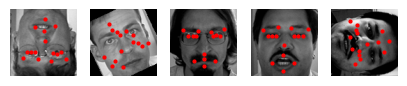

In [17]:
from matplotlib import pyplot as plt

images = pd.DataFrame(data.loc[4000:5000,'Image'])
points = data.iloc[4000:5000,:-1]

def visualize_images_with_points(n_images: int, dataset, shape, points):
    """Visualize n_images images from the dataset."""
    images = dataset.sample(n_images)
    points = points.loc[images.index]
    images = images.apply(
        lambda x: x.str.split(' ', expand=True).astype(np.float32).to_numpy().reshape(shape), axis=1
    ).values

    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.plot(points.values[i][0::2], points.values[i][1::2], 'ro', markersize=2)

        ax.axis('off')

    plt.show()

visualize_images_with_points(5, images, (96, 96), points)

In [10]:
from sklearn.model_selection import train_test_split

data_in_batches = np.array_split(data, 40)

for batch in data_in_batches:
    images = batch['Image'].str.split(' ', expand=True).astype(np.float32).to_numpy().reshape(-1, 96, 96, 1)
    points = batch.iloc[:, :-1]

    train_x, test_x, train_y, test_y = train_test_split(images, points, train_size=0.8)

    model.fit(train_x, train_y, epochs=80, validation_data=(test_x, test_y))

Epoch 1/20
19/19 [==============================] - 7s 375ms/step - loss: 193.5800 - accuracy: 0.4126
Epoch 2/20
19/19 [==============================] - 7s 348ms/step - loss: 181.1932 - accuracy: 0.4193
Epoch 3/20
19/19 [==============================] - 7s 344ms/step - loss: 179.7154 - accuracy: 0.4376
Epoch 4/20
19/19 [==============================] - 7s 359ms/step - loss: 187.4554 - accuracy: 0.4193
Epoch 5/20
19/19 [==============================] - 7s 371ms/step - loss: 189.7624 - accuracy: 0.4642
Epoch 6/20
19/19 [==============================] - 7s 360ms/step - loss: 179.9254 - accuracy: 0.4459
Epoch 7/20
19/19 [==============================] - 7s 346ms/step - loss: 162.0806 - accuracy: 0.5175
Epoch 8/20
19/19 [==============================] - 7s 350ms/step - loss: 166.3604 - accuracy: 0.4426
Epoch 9/20


KeyboardInterrupt: 